In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sqlalchemy import create_engine

### Problem statement

We are preseneted with datasets with regards to airport and their features, airport operations, flight cancellations and diversions in a priod of 10 years, from 2004 to 20014. In addition to the data provided by FAA other data has been gathered from multiple goverment agencies which track and monitor air travel.

Here we are trying to figure out what are the deriving factros behind delays occured on major airports. This project has two major steps, classifing airports into two or more categories, airports with too much delays or bad airports and airports who perform well with less delays, and hence good airports

### Data

The data is from three CSV files. The operations and airport data are imported from files with additional data and columns. Cancellation is kept the same as the CSV file provided.

The files "Airport Operations - Final.ipynb" and "Airport Data - Final.ipynb" can be accessed to see how additional data is merged to exisiting data. 

In [2]:
Airport_cancellations_file = './assets/airport_cancellations.csv'
Airport_operations_file = './Airport_operations_final_df.csv'
Airports_file  = './Airports_final_df.csv'

In [3]:
Airport_cancellations = pd.read_csv(Airport_cancellations_file)
Airport_operations = pd.read_csv(Airport_operations_file)
Airports = pd.read_csv(Airports_file)

### SQLDatabase

In [4]:
engine = create_engine('postgresql://localhost:5432/alikhanzadi')
# conn = engine.connect('postgresql://localhost:5432/alikhanzadi')
# postgres_db = 'project_7.sqlite'
# conn = sqlite3.connect(postgres_db)

In [5]:
# Airport_cancellations.to_sql('airport_cancellation_db', con=engine,if_exists='replace',index=False)
# Airport_operations.to_sql('airport_operations_db',con=engine,if_exists='replace',index=False)
# Airports.to_sql('airports_db',con=engine,if_exists='replace',index=False)

In [6]:
def load_data_from_database(conn,query):
    df = pd.read_sql(query,conn=connection)
    return df

 --------------------------------------------------------------------------------------
 #### Airports


In [7]:
airports_df = Airports

In [8]:
# sql_query """select * from airports"""
# airports_df = load_data_from_database(conn, sql_query)

In [9]:
print airports_df.shape
print "unique airports available: ", len(airports_df.LocID.unique())
print ''
airports_df.info()

(5164, 10)
unique airports available:  5153

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164 entries, 0 to 5163
Data columns (total 10 columns):
LocID            5152 non-null object
ALIAS            3498 non-null object
Facility Type    5164 non-null object
FAA REGION       5164 non-null object
STATE            5164 non-null object
AP Type          5164 non-null object
Latitude         5164 non-null float64
Longitude        5164 non-null float64
ARPElevation     5031 non-null float64
Runway_ct        5031 non-null float64
dtypes: float64(4), object(6)
memory usage: 403.5+ KB


In [10]:
airports_df[airports_df['LocID'] == 'LAX']

,LocID,ALIAS,Facility Type,FAA REGION,STATE,AP Type,Latitude,Longitude,ARPElevation,Runway_ct
954,LAX,Los Angeles Int'l Airport,Airport,AWP,CA,Federalized/Commercial,33.942496,-118.408068,127.0,4.0


 --------------------------------------------------------------------------------------
 #### Cancellations

In [11]:
airport_cancellations_df = Airport_cancellations

In [12]:
# sql_query """select * from airport_cancellation_db"""
# airport_cancellagtions_df = load_data_from_database(conn, sql_query)

In [13]:
print airport_cancellations_df.shape
print "unique airports available: ", len(airport_cancellations_df.Airport.unique())
print ''
airport_cancellations_df.info()

(805, 6)
unique airports available:  74

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 6 columns):
Airport                    805 non-null object
Year                       805 non-null float64
Departure Cancellations    805 non-null float64
Arrival Cancellations      805 non-null float64
Departure Diversions       805 non-null float64
Arrival Diversions         805 non-null float64
dtypes: float64(5), object(1)
memory usage: 37.8+ KB


In [14]:
airport_cancellations_df.describe()

,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
count,805.000000,805.000000,805.000000,805.000000,805.000000
mean,2008.986335,1292.038509,1333.124224,173.315528,169.413665
std,3.158116,1835.961943,1975.224868,172.345539,228.521615
min,2004.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,349.000000,314.000000,62.000000,41.000000
50%,2009.000000,663.000000,642.000000,110.000000,84.000000
75%,2012.000000,1472.000000,1523.000000,236.000000,190.000000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000


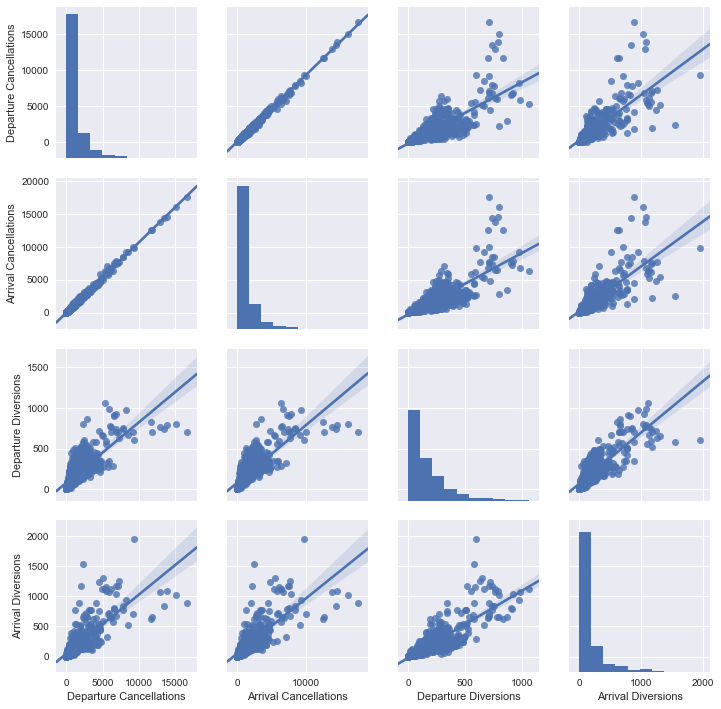

In [15]:
plot_df = airport_cancellations_df[['Departure Cancellations', 'Arrival Cancellations',
                                    'Departure Diversions', 'Arrival Diversions']]
sns.pairplot(plot_df, kind='reg')

There is a clear positive correlation between arrival cancellations  and departure cancellations. Perhaps we can reduce dimenssions here.

 --------------------------------------------------------------------------------------
 #### Operations


The ASPM Airport Analysis module of ASPM provides information on aircraft departure and arrival times and flight delays at selected airports compared to the schedule and flight plan times.
http://aspmhelp.faa.gov/index.php/ASPM_Airport_Analysis_Manual

* **Arrivals/Departures For Metric Computation:** Flight arrivals/departures used for calculating metrics in ASPM. Only the following flight records are included: Itinerant flights to or from one of the ASPM 77 Airports or operated by one of the ASPM Carriers at any airport with flight plan and/ or actual arrival and departure times. General aviation and military flights are excluded. Arrivals/Departures for Metric Computation are aggregated based on the scheduled arrival/departure time if available, otherwise the flight plan arrival/departure time is used.
http://aspmhelp.faa.gov/index.php/ASPM_Airport_Analysis:_Definitions_of_Variables

The Operations Network (OPSNET) is the official source of NAS air traffic operations and delay data. The data collected through OPSNET is used to analyze the performance of the FAA's air traffic control facilities.
http://aspmhelp.faa.gov/index.php/Operations_Network_(OPSNET)

* **Total Operations:** Total facility traffic count, as reported in OPSNET. The traffic count rules determining the number of operations vary by type of facility. For more information on Operations, please see OPSNET.
http://aspmhelp.faa.gov/index.php/OPSNET_Reports:_Definitions_of_Variables

* **Itinerant:** Number of IFR or VFR Itinerant operations sorted by category (Air Carrier, Air Taxi, General Aviation, Military). Itinerant operations are those performed by an aircraft, under IFR or VFR, that lands at an airport arriving from outside the airport area, or departs from an airport and leave the airport area.
http://aspmhelp.faa.gov/index.php/CountOps:_Definitions_of_Variables

In [16]:
airport_operations_df = Airport_operations

In [17]:
# sql_query """select * from airports_db"""
# airports_df = load_data_from_database(conn, sql_query)

In [18]:
airport_operations_df['hub'].unique()

array(['M', 'L', 'S', 'None', 'N'], dtype=object)

** Hub Type: Percentage of Annual Passenger Boardings**

* Large Hub: “large hub airport” means a commercial service airport that has at least 1.0 percent of the passenger boardings.
* Medium Hub: “medium hub airport” means a commercial service airport that has at least 0.25 percent but less than 1.0 percent of the passenger boardings.
* Small Hub: “small hub airport” means a commercial service airport that has at least 0.05 percent but less than 0.25 percent of the passenger boardings.
* Nonhub Primary: “nonhub airport” means a commercial service airport that has less than 0.05 percent of the passenger boardings.

https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/categories/

In [19]:
print airport_operations_df.shape
print "unique airports available: ", len(airport_operations_df.airport.unique())
print ''
airport_operations_df.info()

(841, 19)
unique airports available:  77

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 19 columns):
airport                               841 non-null object
year                                  841 non-null int64
departures for metric computation     841 non-null int64
arrivals for metric computation       841 non-null int64
percent on-time gate departures       841 non-null float64
percent on-time airport departures    841 non-null float64
percent on-time gate arrivals         841 non-null float64
average_gate_departure_delay          841 non-null float64
average_taxi_out_time                 841 non-null float64
average taxi out delay                841 non-null float64
average airport departure delay       841 non-null float64
average airborne delay                841 non-null float64
average taxi in delay                 841 non-null float64
average block delay                   841 non-null float64
average gate arrival delay        

In [20]:
airport_operations_df.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,total Operations,hub,passengers,cargo
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,"197,657",M,3079172,"622,552,578"
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,"196,699",M,3169861,"648,927,044"
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,"192,241",M,3176299,"656,929,174"
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,"190,780",M,3239096,"677,554,390"
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,"180,553",M,3158971,"629,630,968"


 --------------------------------------------------------------------------------------
 #### Merging all data frames into one data frame


In [21]:
cancellations_airports = pd.merge(airport_cancellations_df, airports_df, left_on ='Airport', right_on='LocID')
cancellations_airports = cancellations_airports.drop(['LocID', 'Facility Type'],axis=1)
cancellations_airports.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,ALIAS,FAA REGION,STATE,AP Type,Latitude,Longitude,ARPElevation,Runway_ct
0,ABQ,2004.0,242.0,235.0,71.0,46.0,Albuquerque Int'l Sunport,ASW,NM,Federalized/Commercial,35.040194,-106.609194,5354.0,3.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0,Albuquerque Int'l Sunport,ASW,NM,Federalized/Commercial,35.040194,-106.609194,5354.0,3.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0,Albuquerque Int'l Sunport,ASW,NM,Federalized/Commercial,35.040194,-106.609194,5354.0,3.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0,Albuquerque Int'l Sunport,ASW,NM,Federalized/Commercial,35.040194,-106.609194,5354.0,3.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0,Albuquerque Int'l Sunport,ASW,NM,Federalized/Commercial,35.040194,-106.609194,5354.0,3.0


In [22]:
airports_operations_final_df = pd.merge(cancellations_airports, airport_operations_df,
                                        right_on=['airport', 'year'], left_on=['Airport', 'Year'])
airports_operations_final_df = airports_operations_final_df.drop(['airport', 'year', 'ALIAS', 'STATE', 'AP Type'], axis=1)
airports_operations_final_df.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,FAA REGION,Latitude,Longitude,ARPElevation,...,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,total Operations,hub,passengers,cargo
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ASW,35.040194,-106.609194,5354.0,...,2.43,12.10,2.46,0.83,2.55,10.87,"197,657",M,3079172,"622,552,578"
1,ABQ,2005.0,221.0,190.0,61.0,33.0,ASW,35.040194,-106.609194,5354.0,...,2.29,11.20,2.26,0.89,2.34,10.24,"196,699",M,3169861,"648,927,044"
2,ABQ,2006.0,392.0,329.0,71.0,124.0,ASW,35.040194,-106.609194,5354.0,...,2.16,12.33,2.12,0.84,2.66,11.82,"192,241",M,3176299,"656,929,174"
3,ABQ,2007.0,366.0,304.0,107.0,45.0,ASW,35.040194,-106.609194,5354.0,...,2.40,12.95,2.19,1.29,3.06,12.71,"190,780",M,3239096,"677,554,390"
4,ABQ,2008.0,333.0,300.0,79.0,42.0,ASW,35.040194,-106.609194,5354.0,...,2.41,12.32,1.82,1.03,2.79,11.48,"180,553",M,3158971,"629,630,968"


In [23]:
print airports_operations_final_df.shape
print "unique airports available: ", len(airports_operations_final_df.Airport.unique())
print ''
airports_operations_final_df.info()

(799, 28)
unique airports available:  74

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 28 columns):
Airport                               799 non-null object
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
FAA REGION                            799 non-null object
Latitude                              799 non-null float64
Longitude                             799 non-null float64
ARPElevation                          799 non-null float64
Runway_ct                             799 non-null float64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departure

* **Average Airborne Delay:** The difference between Actual Airborne Time and the flight plan Estimated Time Enroute (Filed ETE), in minutes.
* **Average Airport Departure Delay:** The Actual Wheels Off minus the Scheduled Gate Out plus the Unimpeded Taxi Out time, in minutes. Negative values contribute to the average if the report includes early flights.
* **Average Block Delay:** The difference between Actual Gate-To-Gate time and Scheduled Gate-To-Gate, in minutes.
* **Average Gate Arrival Delay:** The sum of minutes of Gate Arrival Delay of 1 minute or more, divided by all arrivals. Gate Arrival Delay is the difference between the Actual Gate In Time and the Scheduled or Flight Plan Gate In Time.
* **Average Gate Departure Delay:** The sum of minutes of Gate Departure Delay of 1 minute or more, divided by all departures. Gate Departure Delay is the difference between the Actual Gate Out time and Scheduled or Flight Plan Gate Out time, in minutes.
* **Average Taxi Out Delay:** The sum of minutes of Taxi Out Delay of 1 minute or more, divided by all departures. Taxi Out Delay equals Actual Taxi Out Time minus Unimpeded Taxi Out time.
* **Average Taxi Out Time:** The difference between Actual Gate Out time and Actual Wheels Off time, in minutes, divided by the total number of flights. Taxi out time is observed for flights for which OOOI data are available, otherwise it is estimated. See ASPM: Estimation Techniques.
* **Average Taxi In Delay:** The sum of minutes of Taxi In Delay of 1 minute or more, divided by all arrivals. Taxi in Delay equals actual Taxi In Time minus Unimpeded Taxi In Time.

http://aspmhelp.faa.gov/index.php/ASPM_Airport_Analysis:_Definitions_of_Variables

In [24]:
airports_operations_final_df['passengers'] = airports_operations_final_df['passengers'].str.replace(',', '')
airports_operations_final_df['total Operations'] = airports_operations_final_df['total Operations'].str.replace(',', '')
airports_operations_final_df['cargo'] = airports_operations_final_df['cargo'].str.replace(',', '')
airports_operations_final_df['cargo'] = airports_operations_final_df['cargo'].replace(np.nan, '0')

In [25]:
airports_operations_final_df['passengers'] = airports_operations_final_df['passengers'].astype(int)
airports_operations_final_df['total Operations'] = airports_operations_final_df['total Operations'].astype(int)
cargo_col = []
for i in range(len(airports_operations_final_df['cargo'])):
    cell = airports_operations_final_df['cargo'][i]
    cargo_col.append(int(cell))
airports_operations_final_df['cargo'] = cargo_col

In [26]:
airports_operations_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 28 columns):
Airport                               799 non-null object
Year                                  799 non-null float64
Departure Cancellations               799 non-null float64
Arrival Cancellations                 799 non-null float64
Departure Diversions                  799 non-null float64
Arrival Diversions                    799 non-null float64
FAA REGION                            799 non-null object
Latitude                              799 non-null float64
Longitude                             799 non-null float64
ARPElevation                          799 non-null float64
Runway_ct                             799 non-null float64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time 

 --------------------------------------------------------------------------------------
 ### Exporatory Dat Analysis


In [27]:
df_no_airport = airports_operations_final_df.ix[:,1:]
X = pd.get_dummies(df_no_airport)
X.head()

,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Latitude,Longitude,ARPElevation,Runway_ct,departures for metric computation,...,FAA REGION_ANE,FAA REGION_ANM,FAA REGION_ASO,FAA REGION_ASW,FAA REGION_AWP,hub_L,hub_M,hub_N,hub_None,hub_S
0,2004.0,242.0,235.0,71.0,46.0,35.040194,-106.609194,5354.0,3.0,53971,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2005.0,221.0,190.0,61.0,33.0,35.040194,-106.609194,5354.0,3.0,51829,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2006.0,392.0,329.0,71.0,124.0,35.040194,-106.609194,5354.0,3.0,49682,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2007.0,366.0,304.0,107.0,45.0,35.040194,-106.609194,5354.0,3.0,53255,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2008.0,333.0,300.0,79.0,42.0,35.040194,-106.609194,5354.0,3.0,49589,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


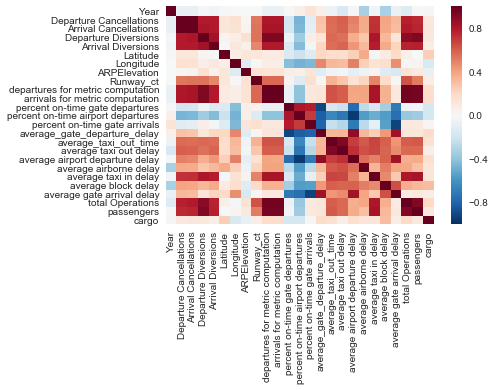

In [28]:
sns.heatmap(df_no_airport.corr())

In [29]:
X.shape

(799, 39)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F8365F8>]], dtype=object)

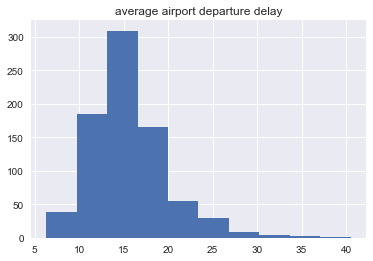

In [30]:
fig = plt.figure(figsize=(10,6))
airports_operations_final_df.hist('average airport departure delay')

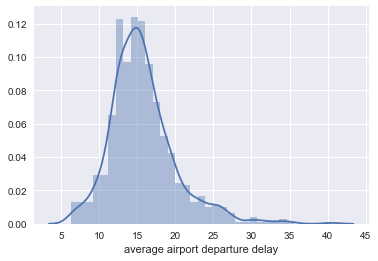

In [31]:
sns.distplot(airports_operations_final_df["average airport departure delay"])

In [32]:
X.corr()["average airport departure delay"].sort_values()

percent on-time airport departures   -0.954832
percent on-time gate departures      -0.764464
percent on-time gate arrivals        -0.712975
FAA REGION_AWP                       -0.366511
hub_M                                -0.277815
hub_None                             -0.182802
FAA REGION_ANM                       -0.160370
ARPElevation                         -0.099154
FAA REGION_ACE                       -0.078285
FAA REGION_ASW                       -0.062081
Year                                 -0.023332
hub_S                                -0.019678
FAA REGION_AAL                        0.008204
hub_N                                 0.023346
FAA REGION_ASO                        0.030101
FAA REGION_ANE                        0.052414
FAA REGION_AGL                        0.060013
Runway_ct                             0.150084
cargo                                 0.167570
Latitude                              0.240283
hub_L                                 0.318347
Departure Div

***It appears that FAA regions except AEA, elevation, and year do not correlate with delay that much.***
The first non -delay- factor contributing to delays is Longitude. This could be do to the fact that flights start east to west and delays in east coast will have an effect on flights on west coast.

In addition, as expected, operations size has a negative effect on departures. Passenger count, arrivals, departures, and then hub size Large, have a postive relationship with delays, which are all indicators of a larger hub.

 --------------------------------------------------------------------------------------
 ### Exporatory Data Analysis


In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [34]:
scaled_data

array([[-1.59340051, -0.57471319, -0.55884073, ..., -0.14744196,
        -0.09401268, -0.43879074],
       [-1.27575405, -0.58612795, -0.58157695, ..., -0.14744196,
        -0.09401268, -0.43879074],
       [-0.95810759, -0.49317926, -0.51134727, ..., -0.14744196,
        -0.09401268, -0.43879074],
       ..., 
       [ 0.94777116, -0.64265814, -0.62351266, ..., -0.14744196,
        -0.09401268,  2.27899066],
       [ 1.26541762, -0.61113168, -0.60027119, ..., -0.14744196,
        -0.09401268,  2.27899066],
       [ 1.58306408, -0.60950101, -0.59926069, ..., -0.14744196,
        -0.09401268,  2.27899066]])

** Distribution for all columns:**

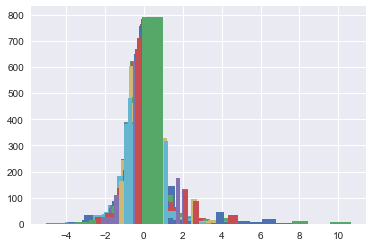

In [35]:
scaled_data_df = pd.DataFrame(scaled_data)
for col in scaled_data_df.columns:
    scaled_data_df[col].hist()

------------------------------------
### PCA
------------------------------------

***The dataset appears to have a normal distribution but some skew to the right.***

In [36]:
X.shape

(799, 39)

In [37]:
pca_1 = PCA(n_components = 5, random_state=0)
X_scaled = pca_1.fit_transform(scaled_data)
pca_1

PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [38]:
sum(pca_1.explained_variance_ratio_[0:2])

0.45149338488855362

** PCA's explained variance result is low. Probably we need to reduce dementiality by dropping unneeded columns.**

In [39]:
reduced_df = airports_operations_final_df.drop(['ARPElevation', 'FAA REGION', 'hub', 'Year'], axis=1)

In [40]:
X_reduced = reduced_df.ix[:,1:]
print X_reduced.shape
X_reduced_scaled = scaler.fit_transform(X_reduced)

(799, 23)


In [41]:
pca_2 = PCA(n_components = 5, random_state=0)

data_pca_2 = pca_2.fit_transform(X_reduced_scaled)
sum(pca_2.explained_variance_ratio_[0:2])

0.6896979995697502

In [55]:
data_pca_2

array([[ -2.81512508e+00,  -7.32677319e-01,  -1.16879472e-02,
         -2.61264641e-02,  -8.00486350e-02],
       [ -3.12799004e+00,  -1.14189339e+00,  -2.09070514e-02,
         -8.59751830e-02,  -1.31978202e-01],
       [ -2.63360311e+00,  -4.46207066e-01,  -2.78351714e-01,
          2.31289350e-01,  -2.62170914e-03],
       ..., 
       [ -3.91749809e+00,  -1.66158850e+00,  -1.93333119e-01,
         -5.96747673e-01,   4.23124090e-01],
       [ -3.20319961e+00,  -2.89955626e-01,  -4.96176806e-01,
         -8.19226836e-02,   4.05532187e-01],
       [ -2.69633242e+00,   6.26538783e-01,  -7.43232339e-01,
          2.82334674e-01,   4.24337038e-01]])

In [42]:
pca_2.components_[0:2]

array([[ 0.259417  ,  0.25926834,  0.25290944,  0.24710232,  0.05526915,
         0.09075783,  0.15755794,  0.26372235,  0.26347417, -0.1209461 ,
        -0.22635516, -0.09672617,  0.15418504,  0.24605451,  0.2464525 ,
         0.23187212,  0.17651135,  0.25889742,  0.18785654,  0.15969445,
         0.25596059,  0.25135885,  0.06051579],
       [-0.0997087 , -0.11071253, -0.19571751, -0.13050745,  0.08800556,
         0.2173848 , -0.17439572, -0.19561368, -0.19623185, -0.33639301,
        -0.26164154, -0.38404987,  0.34009049,  0.03013742,  0.05155986,
         0.26984244,  0.09962454, -0.10794065,  0.14576846,  0.339093  ,
        -0.20173032, -0.20058568,  0.01960182]])

In [45]:
# pca_2_loadings = pd.DataFrame(data_pca_2.T, index)

In [46]:
pca_loading_df = pd.DataFrame(pca_2.components_[0:2].T, columns=['PC1','PC2'], index = \
                                 X_reduced.columns)
pca_loading_df['PC1']

Departure Cancellations               0.259417
Arrival Cancellations                 0.259268
Departure Diversions                  0.252909
Arrival Diversions                    0.247102
Latitude                              0.055269
Longitude                             0.090758
Runway_ct                             0.157558
departures for metric computation     0.263722
arrivals for metric computation       0.263474
percent on-time gate departures      -0.120946
percent on-time airport departures   -0.226355
percent on-time gate arrivals        -0.096726
average_gate_departure_delay          0.154185
average_taxi_out_time                 0.246055
average taxi out delay                0.246452
average airport departure delay       0.231872
average airborne delay                0.176511
average taxi in delay                 0.258897
average block delay                   0.187857
average gate arrival delay            0.159694
total Operations                      0.255961
passengers   

In [47]:
# pca_decomp_df = pd.DataFrame(zip(X_reduced.columns.values, pca_2.components_[0]), columns=["Feature","PC1"])  
# pca_decomp_df["PC2"] = pca_2.components_[1]
# pca_decomp_df.sort_values(by=["PC1","PC2"], ascending=[False,False])

In [48]:
le = LabelEncoder()
y = le.fit_transform(airports_operations_final_df['Airport'])

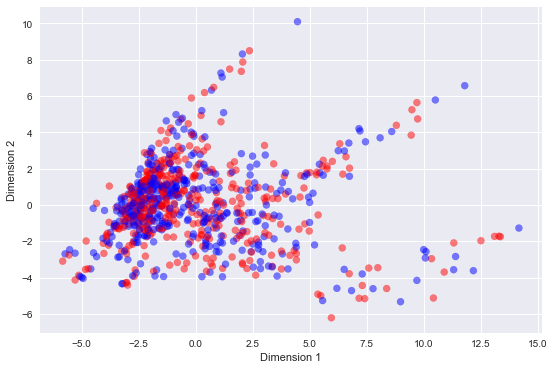

In [49]:
pca2_df = pd.DataFrame(data_pca_2)

fig = plt.figure(figsize=(9,6)) 
plt.scatter(pca2_df[0],pca2_df[1], alpha=0.5, color=['red','blue'])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

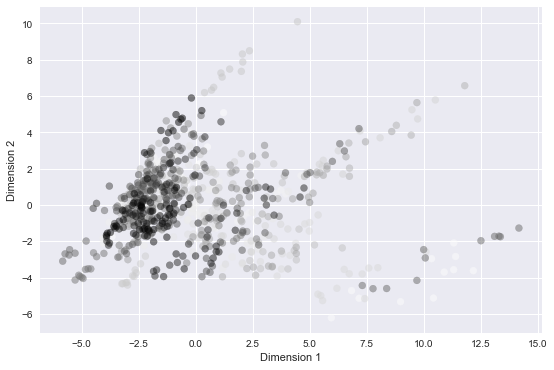

In [59]:

fig = plt.figure(figsize=(9,6)) 
plt.scatter(pca2_df[0],pca2_df[1], c=y, alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

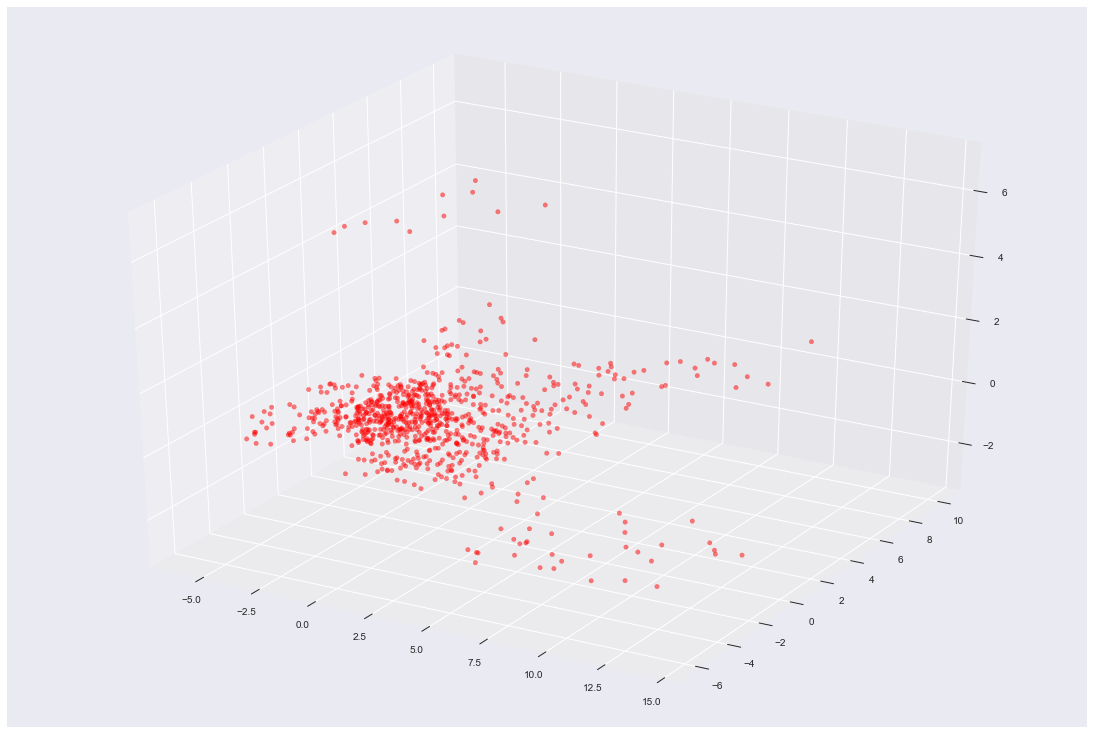

In [69]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure(figsize=(15,10))
axs = Axes3D(ax)
axs.scatter(pca2_df[0], pca2_df[1], pca2_df[2], color=['red','blue','green'], depthshade=True,alpha=0.5)

In [52]:
plt.show()

***The overall explained variance ration has improved. We might still be able to improve this score by reducing the cancellations features into one feature(dimenssion)***

In [53]:
pca2_df

,0,1,2,3,4
0,-2.815125,-0.732677,-0.011688,-0.026126,-0.080049
1,-3.127990,-1.141893,-0.020907,-0.085975,-0.131978
2,-2.633603,-0.446207,-0.278352,0.231289,-0.002622
3,-2.250412,-0.173249,-0.215261,0.155446,0.314918
4,-2.745865,-0.655409,-0.208048,0.088236,0.149281
5,-3.672417,-1.738728,-0.148084,-0.103890,-0.279660
6,-3.337846,-1.137353,-0.363817,0.126358,-0.322161
7,-3.089870,-0.860218,-0.416363,0.128539,-0.345098
8,-3.400271,-1.286425,-0.393031,0.062839,-0.346646
9,-2.512111,0.533294,-0.618583,0.458174,-0.084535


------------------------------------
### tSNE
------------------------------------

In [71]:
print (reduced_df.shape)
reduced_df.head()

(799, 24)


,Airport,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Latitude,Longitude,Runway_ct,departures for metric computation,arrivals for metric computation,...,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,total Operations,passengers,cargo
0,ABQ,242.0,235.0,71.0,46.0,35.040194,-106.609194,3.0,53971,53818,...,9.89,2.43,12.10,2.46,0.83,2.55,10.87,197657,3079172,622552578
1,ABQ,221.0,190.0,61.0,33.0,35.040194,-106.609194,3.0,51829,51877,...,9.79,2.29,11.20,2.26,0.89,2.34,10.24,196699,3169861,648927044
2,ABQ,392.0,329.0,71.0,124.0,35.040194,-106.609194,3.0,49682,51199,...,9.89,2.16,12.33,2.12,0.84,2.66,11.82,192241,3176299,656929174
3,ABQ,366.0,304.0,107.0,45.0,35.040194,-106.609194,3.0,53255,53611,...,10.34,2.40,12.95,2.19,1.29,3.06,12.71,190780,3239096,677554390
4,ABQ,333.0,300.0,79.0,42.0,35.040194,-106.609194,3.0,49589,49512,...,10.41,2.41,12.32,1.82,1.03,2.79,11.48,180553,3158971,629630968


In [73]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_reduced)

In [74]:
tsne_data.shape

(799L, 2L)

In [121]:
# tsne_reduced_df = reduced_df.drop(['Departure Cancellations', 'Arrival Cancellations', 
#                                   'Departure Diversions', 'Arrival Diversions'],axis=1)
# tsne_reduced_df['can_dep'] = cancellations_tsne

In [125]:
# X_reduced_2 = tsne_reduced_df.ix[:,1:]
# X_reduced_2_scaled = scaler.fit_transform(X_reduced_2)
# pca_3 = PCA(n_components = 5, random_state=0)

# data_pca_3 = pca_3.fit_transform(X_reduced_2_scaled)
# sum(pca_3.explained_variance_ratio_[0:2])

0.64237300143071252

In [124]:
tsne_reduced_df

,Airport,Latitude,Longitude,Runway_ct,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,...,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,total Operations,passengers,cargo,can_dep
0,ABQ,35.040194,-106.609194,3.0,53971,53818,0.8030,0.7809,0.7921,10.38,...,2.43,12.10,2.46,0.83,2.55,10.87,197657,3079172,622552578,2.307776
1,ABQ,35.040194,-106.609194,3.0,51829,51877,0.8140,0.7922,0.8001,9.60,...,2.29,11.20,2.26,0.89,2.34,10.24,196699,3169861,648927044,4.086942
2,ABQ,35.040194,-106.609194,3.0,49682,51199,0.7983,0.7756,0.7746,10.84,...,2.16,12.33,2.12,0.84,2.66,11.82,192241,3176299,656929174,-25.703504
3,ABQ,35.040194,-106.609194,3.0,53255,53611,0.8005,0.7704,0.7647,11.29,...,2.40,12.95,2.19,1.29,3.06,12.71,190780,3239096,677554390,-17.733241
4,ABQ,35.040194,-106.609194,3.0,49589,49512,0.8103,0.7844,0.7875,10.79,...,2.41,12.32,1.82,1.03,2.79,11.48,180553,3158971,629630968,-18.389536
5,ABQ,35.040194,-106.609194,3.0,42550,42704,0.8341,0.8147,0.8224,9.24,...,1.89,10.45,1.74,0.92,1.98,9.27,158529,2881798,579793842,10.084039
6,ABQ,35.040194,-106.609194,3.0,42302,42169,0.8144,0.7907,0.8047,10.25,...,2.05,11.58,1.66,0.95,1.90,10.23,156616,2828420,598981698,4.321307
7,ABQ,35.040194,-106.609194,3.0,42283,42297,0.8072,0.7758,0.8022,10.81,...,2.51,12.57,1.58,0.84,1.87,10.63,154140,2768435,593136032,-16.022947
8,ABQ,35.040194,-106.609194,3.0,39105,39107,0.8219,0.7940,0.8177,10.55,...,2.32,12.11,1.41,0.98,1.80,9.73,147724,2630574,568151446,4.217723
9,ABQ,35.040194,-106.609194,3.0,35277,34989,0.7710,0.7402,0.7554,12.56,...,2.64,14.28,1.60,0.92,2.35,12.76,136915,2477783,567236072,2.390984


In [123]:
reduced_df.columns

Index([u'Airport', u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions', u'Latitude',
       u'Longitude', u'Runway_ct', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay',
       u'total Operations', u'passengers', u'cargo'],
      dtype='object')

### Clusters

In [60]:
import renders as rs

In [63]:
for i in range(2,10):
    km = KMeans(n_clusters=i)
    km.fit(X_reduced)
    print "for ",i, " clusters, silhouette score is:", silhouette_score(X_reduced, labels=km.labels_, metric='euclidean')

for  2  clusters, silhouette score is: 0.890423879515
for  3  clusters, silhouette score is: 0.787595571907
for  4  clusters, silhouette score is: 0.750172584081
for  5  clusters, silhouette score is: 0.727628676243
for  6  clusters, silhouette score is: 0.633749643499
for  7  clusters, silhouette score is: 0.646677838564
for  8  clusters, silhouette score is: 0.615919248617
for  9  clusters, silhouette score is: 0.590491529512


The score is best with two clusters.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.43215688897409416)


KeyError: 'Dimension 1'

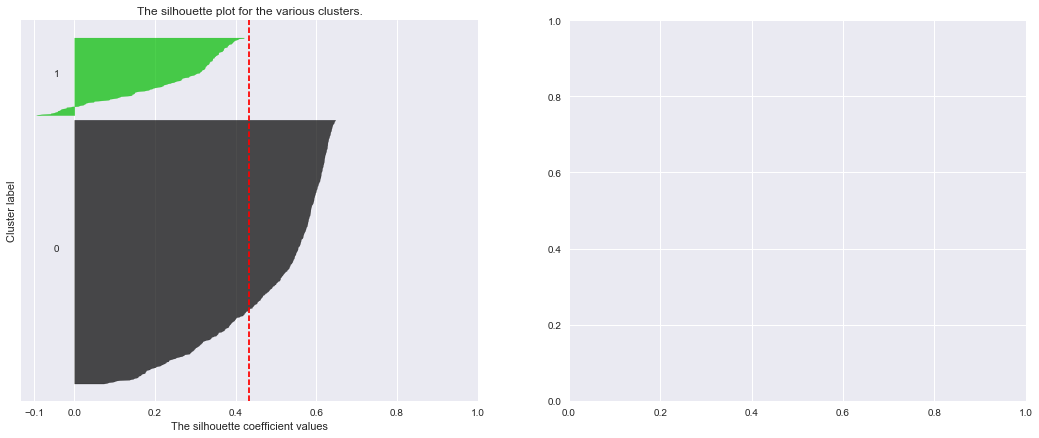

In [62]:
rs.plots_for_n_clusters(pca2_df, 2)

In [75]:
pca2_df

,0,1,2,3,4
0,-2.815125,-0.732677,-0.011688,-0.026126,-0.080049
1,-3.127990,-1.141893,-0.020907,-0.085975,-0.131978
2,-2.633603,-0.446207,-0.278352,0.231289,-0.002622
3,-2.250412,-0.173249,-0.215261,0.155446,0.314918
4,-2.745865,-0.655409,-0.208048,0.088236,0.149281
5,-3.672417,-1.738728,-0.148084,-0.103890,-0.279660
6,-3.337846,-1.137353,-0.363817,0.126358,-0.322161
7,-3.089870,-0.860218,-0.416363,0.128539,-0.345098
8,-3.400271,-1.286425,-0.393031,0.062839,-0.346646
9,-2.512111,0.533294,-0.618583,0.458174,-0.084535
